Step 1: Import library

In [80]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Load Dataset

In [81]:
def load_file(filepath, label):
    sentences = []
    labels = []

    with open(filepath, encoding='latin-1') as f:
        for line in f:
            sentences.append(line.strip())
            labels.append(label)

    return pd.DataFrame({'text': sentences, 'label': labels})

df_fact = load_file("plot.tok.gt9.5000", 0)
df_opinion = load_file("quote.tok.gt9.5000", 1)

df = pd.concat([df_fact, df_opinion]).reset_index(drop=True)

print(df['label'].value_counts())


label
0    5000
1    5000
Name: count, dtype: int64


Step 3: Text Cleaning

In [82]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['clean_text'] = df['text'].apply(clean_text)


Step 4: Train-Test Split

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


**Classical ML Models**

Step 5: TF-IDF vectorization

In [84]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Step 6: Implementing ML Models

In [85]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

results = {}

# 1️⃣ Naive Bayes
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Report:\n")
print(classification_report(y_test, y_pred_nb))

results["Naive Bayes"] = accuracy_score(y_test, y_pred_nb)


# 2️⃣ Logistic Regression
lr = LogisticRegression(C=1.5, max_iter=2000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("\nLogistic Regression Report:\n")
print(classification_report(y_test, y_pred_lr))

results["Logistic Regression"] = accuracy_score(y_test, y_pred_lr)


# 3️⃣ SVM
svm = LinearSVC(C=1.5)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print("\nSVM Report:\n")
print(classification_report(y_test, y_pred_svm))

results["SVM"] = accuracy_score(y_test, y_pred_svm)


print("\nClassical ML Accuracy Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc*100:.2f}%")


Naive Bayes Report:

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1000
           1       0.90      0.93      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000


Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1000
           1       0.90      0.90      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000


SVM Report:

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1000
           1       0.90      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted 

**BiLSTM Model**

Step 7:Tokenization & Padding

In [86]:
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 200

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


Step 8: Build BiLSTM Model

In [87]:
model = Sequential([
    Embedding(input_dim=15000, output_dim=200, input_length=max_len),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(32)),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Step 9: Train model (with EarlyStopping)

In [89]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1
)

history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 179s 822ms/step - accuracy: 0.6988 - loss: 0.5249 - val_accuracy: 0.8838 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9664 - loss: 0.1186
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 ━━━━━━━━━━━━━━━━━━━━ 151s 755ms/step - accuracy: 0.9664 - loss: 0.1186 - val_accuracy: 0.9000 - val_loss: 0.2789 - learning_rate: 0.0010
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.9930 - loss: 0.0319
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 813ms/step - accuracy: 0.9930 - loss: 0.0319 - val_accuracy: 0.8969 - val_loss: 0.3521 - learning_rate: 5.0000e-04


Step 10: Evaluate BiLSTM

In [90]:
y_pred_prob = model.predict(X_test_pad)
y_pred_dl = (y_pred_prob > 0.5).astype("int32").reshape(-1)


print("\nBiLSTM Classification Report:\n")
print(classification_report(y_test, y_pred_dl))

dl_accuracy = accuracy_score(y_test, y_pred_dl)
results["BiLSTM"] = dl_accuracy

print("BiLSTM Accuracy: {:.2f}%".format(dl_accuracy * 100))


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 233ms/step

BiLSTM Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1000
           1       0.91      0.93      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

BiLSTM Accuracy: 91.70%


Step 11: Confusion Matrix (BiLSTM)

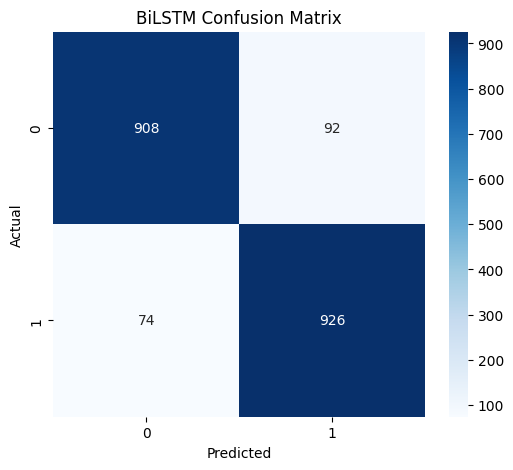

In [91]:
cm = confusion_matrix(y_test, y_pred_dl)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BiLSTM Confusion Matrix")
plt.show()


**Final Comparison**

In [92]:
results_df = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy (%)": [acc*100 for acc in results.values()]
})

results_df = results_df.sort_values(by="Accuracy (%)", ascending=False)

print("\nFinal Model Comparison:")
print(results_df)



Final Model Comparison:
                 Model  Accuracy (%)
3               BiLSTM         91.70
0          Naive Bayes         91.55
1  Logistic Regression         90.00
2                  SVM         89.20


**CROSS-VALIDATION (For Classical Models)**

In [93]:
from sklearn.model_selection import cross_val_score

print("\n5-Fold Cross Validation (Accuracy):\n")

nb_cv = cross_val_score(nb, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Naive Bayes CV Accuracy: {:.2f}%".format(nb_cv.mean()*100))

lr_cv = cross_val_score(lr, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Logistic Regression CV Accuracy: {:.2f}%".format(lr_cv.mean()*100))

svm_cv = cross_val_score(svm, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("SVM CV Accuracy: {:.2f}%".format(svm_cv.mean()*100))



5-Fold Cross Validation (Accuracy):

Naive Bayes CV Accuracy: 90.18%
Logistic Regression CV Accuracy: 89.34%
SVM CV Accuracy: 88.94%


**F1-SCORE COMPARISON TABLE**

In [94]:
from sklearn.metrics import f1_score

results_f1 = {}

results_f1["Naive Bayes"] = f1_score(y_test, y_pred_nb)
results_f1["Logistic Regression"] = f1_score(y_test, y_pred_lr)
results_f1["SVM"] = f1_score(y_test, y_pred_svm)
results_f1["BiLSTM"] = f1_score(y_test, y_pred_dl)

f1_df = pd.DataFrame({
    "Model": results_f1.keys(),
    "F1 Score": results_f1.values()
})

print("\nF1 Score Comparison:")
print(f1_df)



F1 Score Comparison:
                 Model  F1 Score
0          Naive Bayes  0.916708
1  Logistic Regression  0.900000
2                  SVM  0.891457
3               BiLSTM  0.917740


**ROC CURVE**

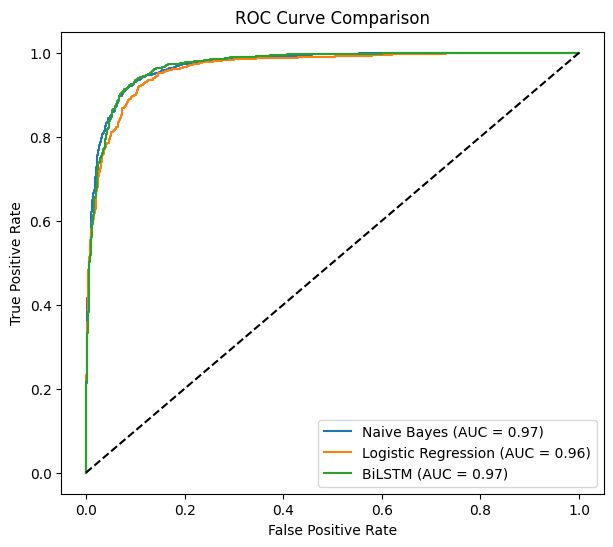

In [95]:
y_prob_lr = lr.predict_proba(X_test_tfidf)[:,1]
y_prob_nb = nb.predict_proba(X_test_tfidf)[:,1]
y_prob_dl = y_pred_prob.reshape(-1)


from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,6))

for name, y_prob in {
    "Naive Bayes": y_prob_nb,
    "Logistic Regression": y_prob_lr,
    "BiLSTM": y_prob_dl
}.items():

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


****

In [99]:

from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd

# Create contingency table comparing correctness of two models
# True = prediction correct, False = prediction wrong

nb_correct = (y_pred_nb == y_test)
dl_correct = (y_pred_dl == y_test)

# Build 2x2 contingency table
table = pd.crosstab(nb_correct, dl_correct)

print("Contingency Table (NB vs BiLSTM):")
print(table)

# McNemar Test
result = mcnemar(table, exact=True)

print("\nMcNemar Test p-value:", result.pvalue)

if result.pvalue < 0.05:
    print("Result: Statistically significant difference between models.")
else:
    print("Result: No statistically significant difference between models.")



Contingency Table (NB vs BiLSTM):
label  False  True 
label              
False     87     82
True      79   1752

McNemar Test p-value: 0.8748178672015423
Result: No statistically significant difference between models.
